# Spatial and Temporal Correlation Analysis

This tutorial demonstrates: 

1. how to extract time series of one grid cell and compare with point measurement

2. how to map the statistical relationship between two spatio-temporal variables. 

It also covers the following technical concepts:

* using THREDDS and [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP), and getting information on file dimensions
* subsetting netCDF data from OPeNDAP
* grid extraction
* linear and rank correlation and their statistical significance.
* grid resampling

In [1]:
# As usual, we start with our imports
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style('dark')

### 1. validation of soil moisture estimation

In this task, we will evaluate the surface soil moisture estimation from S-GRAFS (Satellite-Guided Root-zone Analysis and Forecasting System) with in-situ soil moisture measurements from OzFlux network.

The S-GRAFS provides a 'data-heavy, model-lite' estimates of surface soil wetness and root-zone soil wetness,  developed by Siyuan Tian and Luigi Renzullo from ANU-WALD. The near real-time passive microwave retrievals of top-layer (0-5 cm) soil moisture from the Soil Moisture Active/Passive (SMAP) were assimilated into a satellite rainfall (GPM, Global Precipitation Mission) driven soil moisture modelling system. 

OzFlux is a national ecosystem research network set up to provide the Australian and global ecosystem modelling communities with nationally consistent observations of energy, carbon and water exchange between the atmosphere and key Australian ecosystems.

These data are on the National Computational Infrastructure (NCI) and available through THREDDS:

S-GRAFS: 
http://dapds00.nci.org.au/thredds/catalog/ub8/au/S-GRAFS/catalog.html
OzFlux:
http://dap.ozflux.org.au/thredds/catalog.html


<img src="./OzFlux_sites.png" alt="drawing" width="1000" align="left"/>

### 1.1 loading and subsetting model data

We will look at daily soil moisture at 10km resolution from S-GRAFS for a region in south western New South Wales [-34.5, -36],[145.5, 147.000]

In [2]:
grafs_url = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/au/S-GRAFS/Surface_Wetness_from_API_analysis_window_Australia_2016.nc'

In [3]:
ds = xr.open_dataset(grafs_url)
ds

<xarray.Dataset>
Dimensions:  (lat: 342, lon: 422, time: 366)
Coordinates:
  * lat      (lat) float32 -9.95 -10.05 -10.15 -10.25 ... -43.85 -43.95 -44.05
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-12-31
  * lon      (lon) float32 111.95 112.05 112.15 112.25 ... 153.85 153.95 154.05
Data variables:
    wetness  (time, lat, lon) float32 ...
Attributes:
    date_created:  20190814T200528
    history:       Tue Feb  4 12:19:52 2020: ncks -d lat,-44.05,-9.90 -d lon,...
    NCO:           netCDF Operators version 4.7.7 (Homepage = http://nco.sf.n...

In [4]:
# select all the data in the bounding box
lat_bounds = slice(-34.5, -36)
lon_bounds = slice(145.5, 147.000)
grafs_s0 = ds.sel(lat=lat_bounds, lon=lon_bounds)

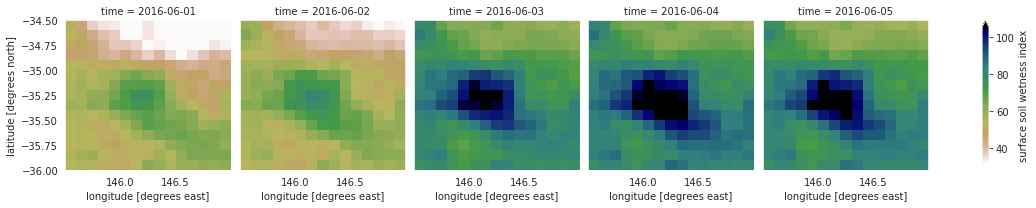

In [5]:
# plot the soil wetness for selected days
grafs_s0.wetness.sel(time=slice('2016-06-01','2016-06-05')).plot.imshow(col='time',col_wrap=5, \
                                                                        cmap='gist_earth_r',robust=True)

### 1.2 extracting time series 

There is one soil moinitoring site from OzFlux network in this region called 'Yanco'. The GPS coordinates is -34.9893, 146.2907. 

We will extract the time series of soil wetness for the closest grid cell and compare with in-situ measurements

In [6]:
# find the nearest model grid 
grafs_yanco = grafs_s0.wetness.sel(lat=-34.9893,lon=146.2907,method='nearest')

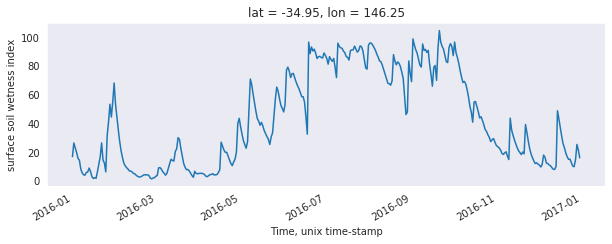

In [7]:
# plot the time-series of model-simulated soil wetness
plt.figure(figsize=(10,3))
grafs_yanco.plot()

### 1.3 loading and processing the in-situ soil moisture measurements

The gound measurements of soil moisture is collected every 30mins. We will need to resample the data to daily average and compare with model simulation. Note that in-situ data always contain gaps or suspicious values. Data filtering is required. 

The data variable for surface soil moisture in the netCDF is called 'Sws'. 

In [8]:
yanco_insitu = 'http://dap.ozflux.org.au/thredds/dodsC/ozflux/sites/Yanco/L3/default/Yanco_L3.nc'
yanco = xr.open_dataset(yanco_insitu)

In [9]:
# 30min data
yanco.time

<xarray.DataArray 'time' (time: 111300)>
array(['2013-01-01T00:30:00.000000000', '2013-01-01T01:00:00.000000000',
       '2013-01-01T01:30:00.000000000', ..., '2019-05-08T17:00:00.000000000',
       '2019-05-08T17:30:00.000000000', '2019-05-08T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01T00:30:00 ... 2019-05-08T18:00:00
Attributes:
    long_name:      time
    standard_name:  time

/g/data/oe9/software/miniconda3/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


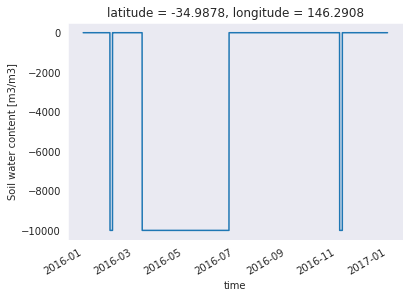

In [10]:
# plot the data for 2016 
yanco.sel(time=slice('2016-01-01','2016-12-31')).Sws.plot()

In [11]:
# the missing values were saved as -9999 
yanco.sel(time=slice('2016-01-01','2016-12-31')).Sws.min()

<xarray.DataArray 'Sws' ()>
array(-9999.)

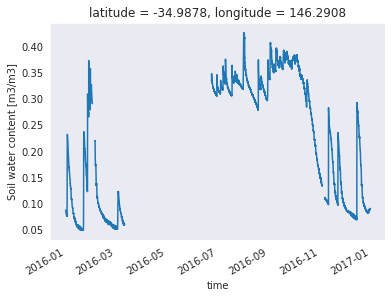

In [12]:
# select soil moisture for 2016 only and asign any negative soil moisture values to NaN
yanco_SM = yanco.sel(time=slice('2016-01-01','2016-12-31')).Sws
yanco_SM.data[yanco_SM.data<0] = np.nan
yanco_SM.plot()

/g/data/oe9/software/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


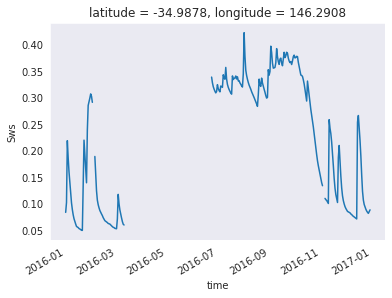

In [13]:
# resample the 0.5 hourly data to daily data using the mean method
yanco_daily = yanco_SM.resample(time='1D').mean().squeeze()
yanco_daily.plot()

Text(0.5, 1.0, '')

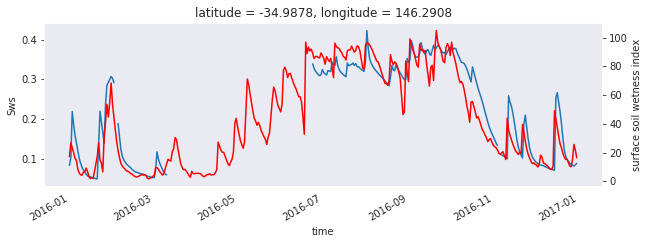

In [14]:
# compare the model simulated soil moisture with in-situ measurments

# plot them in two yaxis since they have different units. 

fig, ax = plt.subplots(figsize=(10,3))
yanco_daily.plot(ax=ax) # in-situ
grafs_yanco.plot(ax=ax.twinx(), color='red') # model 
plt.title('')

### 1.4  correlation analysis

we will use the `pearsonr` and `spearmanr` functions from SciPy
to calculate the correlation between model soil moisture and in-situ soil moisture.
The linear (or Pearson, or parametric) correlation coefficient is the most 
commonly measure the strength of the relationship between two variables. It 
is particularly well suited if both variables are close to normally distributed 
and a linear relationship can be assumed. If the relationship seems non-linear,
then it would be better to calculate the rank(or Spearman, or non-parametric) correlation coefficient.

In any event, it is always a good idea to always check whether the rank 
correlation is very different from the linear correlation coefficient. If the 
two approaches produce _R_- and _p_-values, that lead to similar conclusions, 
then that strengthens your analysis. 

In [15]:
# import modules
from scipy.stats import linregress, pearsonr, spearmanr

In [16]:
linregress(yanco_daily, grafs_yanco)

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)

In [17]:
# NaNs have to be removed
notnan = np.where((~np.isnan(yanco_daily))*(~np.isnan(grafs_yanco)))

In [18]:
linregress(yanco_daily[notnan], grafs_yanco[notnan])

LinregressResult(slope=273.1750443398504, intercept=-14.187167969418098, rvalue=0.9409853824698936, pvalue=1.8761772984407324e-122, stderr=6.140858542752093)

In [19]:
spearmanr(yanco_daily[notnan], grafs_yanco[notnan])

SpearmanrResult(correlation=0.9209848057916106, pvalue=8.528332415899099e-107)

In [20]:
pearsonr(yanco_daily[notnan], grafs_yanco[notnan])

(0.9409853824698934, 1.8761772984419897e-122)

## 2 statistical relationship between two spatio-temporal variables

It is well kown that fuel moisture content (FMC) is an important fuel property for assessing wildfire hazard, since it influences fuel flammability and fire behavior.

What about surface soil moisture? If surface is wet, the fire risk should be low. There should be a strong negative correlation. Let's have a look at the soil moisture conditions and flammability over the grassland areas in this region

The flammability data were developed by Marta Yebra using MODIS data and the data are available here: http://dapds00.nci.org.au/thredds/catalog/ub8/au/FMC/c6/mosaics/catalog.html

The flammability data is updated very 8-day. To simply the case, we will resample the data to monthly data.

### 2.1 comparing data with different time and spatial resolution

In [21]:
flam_url = 'http://dapds00.nci.org.au/thredds/dodsC/ub8/au/FMC/c6/mosaics/flam_c6_2016.nc'
flammability = xr.open_dataset(flam_url).sel(latitude=lat_bounds, longitude=lon_bounds)
flam_monthly = flammability.resample(time='1M').mean()

/g/data/oe9/software/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [22]:
# resample the soil moisture data to monthly soil moisture
grafs_s0_monthly = grafs_s0.resample(time='1M').mean()

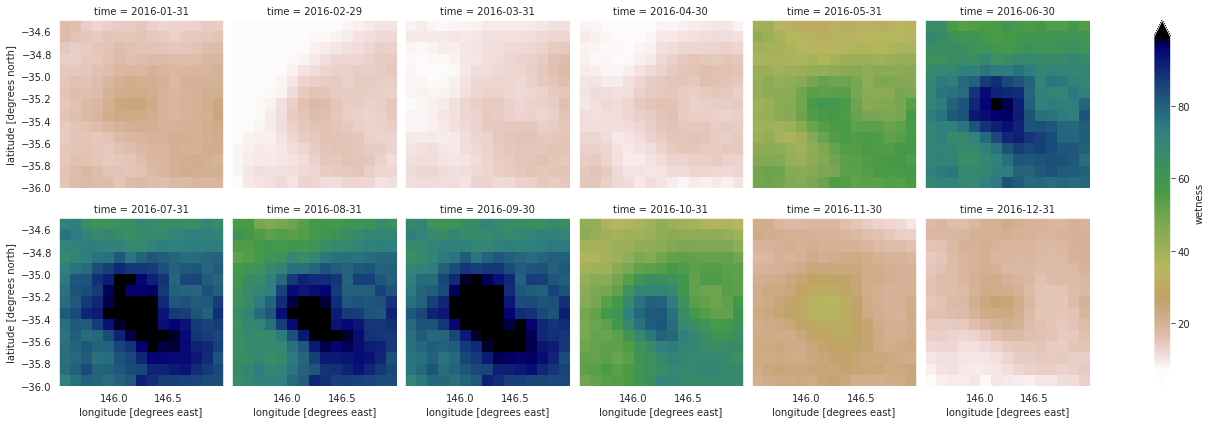

In [23]:
grafs_s0_monthly.wetness.plot.imshow(col='time',col_wrap=6, cmap='gist_earth_r',robust=True)

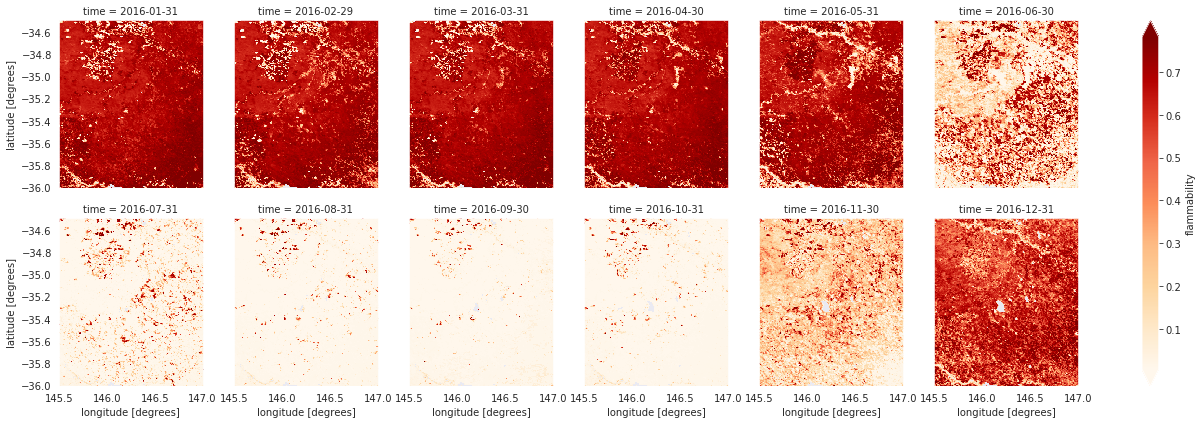

In [24]:
flam_monthly.flammability.plot.imshow(col='time',col_wrap=6, cmap='OrRd',robust=True)

### 2.2 resample the data to a same spatial resolution

The flammability data is ~0.005deg resolution, whereas the soil moisture is 0.1deg. We will use the funtion `griddata` from scipy.interpolate to resample flammability data to 10km to be consistent with soil moisture data

In [25]:
from scipy.interpolate import griddata

In [26]:
help(griddata)

Help on function griddata in module scipy.interpolate.ndgriddata:

griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
    Interpolate unstructured D-dimensional data.
    
    Parameters
    ----------
    points : ndarray of floats, shape (n, D)
        Data point coordinates. Can either be an array of
        shape (n, D), or a tuple of `ndim` arrays.
    values : ndarray of float or complex, shape (n,)
        Data values.
    xi : 2-D ndarray of float or tuple of 1-D array, shape (M, D)
        Points at which to interpolate data.
    method : {'linear', 'nearest', 'cubic'}, optional
        Method of interpolation. One of
    
        ``nearest``
          return the value at the data point closest to
          the point of interpolation.  See `NearestNDInterpolator` for
          more details.
    
        ``linear``
          tessellate the input point set to n-dimensional
          simplices, and interpolate linearly on each simplex.  See
          `Li

In [27]:
# use np.meshgrid to make N-D coordinate arrays for vectorized evaluations of N-D scalar/vector fields over N-D grids
lon,lat = np.meshgrid(flam_monthly.longitude,flam_monthly.latitude.data) #original resolution
lonnew,latnew = np.meshgrid(grafs_s0.lon,grafs_s0.lat) #target resolution
lonnew.shape

(15, 15)

In [28]:
data = flam_monthly.isel(time=1).flammability.data
output = griddata((lat.ravel(),lon.ravel()),\
                      data.ravel(),(latnew,lonnew), method='linear',fill_value=np.nan)

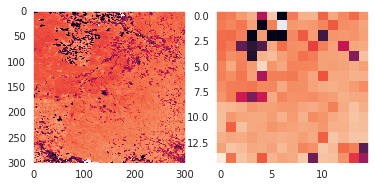

In [29]:
# checked the output of the resampled data
plt.subplot(121)
plt.imshow(data)
plt.subplot(122)
plt.imshow(output)

In [30]:
# create a dataset for the resampled flammability 
flam_10km = xr.Dataset(coords={'latitude': grafs_s0.lat.data, 'longitude': grafs_s0.lon.data,'time':flam_monthly.time})
flam_10km['flammability'] = (('time','latitude','longitude'), np.zeros((12,15,15)))
flam_10km.attrs = flam_monthly.attrs

In [ ]:
# for all time step 
for timestamp in flam_monthly.time:
    # Start by selecting the timestamp
    print(timestamp.data)
    data = flam_monthly.sel(time=timestamp).flammability.data
    output = griddata((lat.ravel(),lon.ravel()),\
                      data.ravel(),(latnew,lonnew), method='linear',fill_value=np.nan)
    output[output<0] = 0
    flam_10km.flammability.sel(time=timestamp)[:] = output
     

2016-01-31T00:00:00.000000000


/g/data/oe9/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


2016-02-29T00:00:00.000000000
2016-03-31T00:00:00.000000000
2016-04-30T00:00:00.000000000
2016-05-31T00:00:00.000000000
2016-06-30T00:00:00.000000000


In [ ]:
# plot the time series
flam_10km.flammability.plot.imshow(col='time',col_wrap=6, cmap='OrRd',robust=True)

### 2.3 can you calculate the correlation between soil wetness and flammability for each pixel?

In [ ]:
r = np.zeros((15,15)).reshape((-1))*np.nan
for i in range(0,15*15):
    x = flam_10km.flammability.data.reshape((12,-1))[:,i]
    y = grafs_s0_monthly.wetness.data.reshape((12,-1))[:,i]
    notnan = np.where((~np.isnan(x))*(~np.isnan(y)))[0]
    if len(notnan)>2:
        r[i] = pearsonr(x[notnan],y[notnan])[0]


In [ ]:
flam_10km['r'] = (('latitude','longitude'),r.reshape((15,15)))
plt.figure(figsize=(6,5))
flam_10km.r.plot.imshow()